In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Loading the data to analyze

In [2]:
p_ = r"/Users/jenifervivar/Documents/GitHub/OceanBasaltML/basalts thesis/src/data/combined_datasets"
combined_df = pd.read_csv(p_)
p = "/Users/jenifervivar/Documents/GitHub/OceanBasaltML/basalts thesis/src/data/variables_target_file"
sampled_df = pd.read_csv(p)
col = sampled_df.columns[:-3].values

In [3]:
col

array(['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MnO', 'MgO', 'CaO', 'Na2O',
       'K2O', 'P2O5', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Ba', 'La', 'Ce', 'Pr',
       'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
       'Hf', 'Ta', 'Th', 'U', 'Cr', 'Ni'], dtype=object)

### The StandardScaler module is used to normalized (mean 0 and std 1) the data so that I can better compare the features

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_standard = scaler.fit_transform(sampled_df[col])
sampled_df[col] = x_standard
combined_df[col] = x_standard

`Below I add the ratios that are tradionalilly compared in the geologist community to determine the type of tectonic setting base on their chemistry trace. Geologist look at isotopes and their ratios when compared to the natural components in each basalt. The main ratios analyzed are: SiO vs Nb/Y, SiO vs, FeOT/MgO, La/Sm vs Zr/Nb, Y/Nb vs Zr/Nb`

In [5]:
sampled_df.columns

Index(['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O',
       'P2O5', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm',
       'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'Th',
       'U', 'Cr', 'Ni', 'LATITUDE', 'LONGITUDE', 'Tectonic_setting'],
      dtype='object')

## adding commonly used ratios

In [6]:
sampled_df["Nb/Y"] = sampled_df["Nb"]/sampled_df["Y"]
sampled_df["FeOT/MgO"]= sampled_df["FeOT"]/sampled_df["MgO"]
sampled_df["La/Sm"] = sampled_df["La"]/sampled_df["Sm"]
sampled_df["Zr/Nb"] = sampled_df["Zr"]/sampled_df["Nb"]
sampled_df["Y/Nb"]= sampled_df["Y"]/sampled_df["Nb"]

In [7]:
sampled_df["Nb/La"] = sampled_df["Nb"]/sampled_df["La"]
sampled_df["Th/Yb"] = sampled_df["Th"]/sampled_df["Yb"]
sampled_df["Zr/Y"] = sampled_df["Zr"]/sampled_df["Y"]
#sampled_df["Th/Yb"] = sampled_df["Th"]/sampled_df["Yb"]

In [8]:
newColsNames = np.array(["Nb/Y","FeOT/MgO","La/Sm","Zr/Nb","Y/Nb", "Nb/La", "Th/Yb", "Zr/Y"])

In [9]:
#selecting the old features and the newly added features
features = np.append(col, newColsNames)
X = sampled_df[features]


In [10]:
#this fucntions makes it easy to train a random forest tree witout copying and pasting the dame code

def randomForestTraining(x, y, df, features):
    from sklearn.model_selection import train_test_split
    # X = sampled_df[col], y = sampled_df["Tectonic_setting"]
    X_train, X_test, y_train, y_test = train_test_split(x, y,\
                                                        test_size=0.3, random_state=100)

    from imblearn.over_sampling import RandomOverSampler
    over_sampler = RandomOverSampler(random_state=42)
    X_bal, y_bal = over_sampler.fit_resample(X_train, y_train)


    from sklearn.ensemble import RandomForestClassifier
    labels = df[features].columns.to_list()
    rf = RandomForestClassifier(n_estimators = 500, random_state = 1)
    rf.fit(X_bal, y_bal)
    
    feature_importance = rf.feature_importances_
    indices = np.argsort(feature_importance)[::-1]

    y_result= rf.predict(X_test)
    from sklearn.metrics import classification_report
    print(classification_report(y_test, y_result))

    return feature_importance[indices], y_result,y_test, X_test, rf

In [11]:
sampled_df.columns[:]

Index(['SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O',
       'P2O5', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm',
       'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'Th',
       'U', 'Cr', 'Ni', 'LATITUDE', 'LONGITUDE', 'Tectonic_setting', 'Nb/Y',
       'FeOT/MgO', 'La/Sm', 'Zr/Nb', 'Y/Nb', 'Nb/La', 'Th/Yb', 'Zr/Y'],
      dtype='object')

## permutation_importance --> This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.



In [13]:
from sklearn.model_selection import train_test_split
# X = sampled_df[col], y = sampled_df["Tectonic_setting"]
X_train, X_test, y_train, y_test = train_test_split(X,sampled_df["Tectonic_setting"],\
                                                    test_size=0.3, random_state=100)

from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_bal, y_bal = over_sampler.fit_resample(X_train, y_train)


from sklearn.ensemble import RandomForestClassifier
labels = sampled_df[features].columns.to_list()
rf = RandomForestClassifier(n_estimators = 500, random_state = 1)

rf.fit(X_bal, y_bal)

from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=labels)

Error processing line 1 of /Users/jenifervivar/opt/anaconda3/lib/python3.9/site-packages/google_auth-1.4.2-py2.7-nspkg.pth:

  Traceback (most recent call last):
    File "/Users/jenifervivar/opt/anaconda3/lib/python3.9/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored
Error processing line 1 of /Users/jenifervivar/opt/anaconda3/lib/python3.9/site-packages/google_auth-1.4.2-py2.7-nspkg.pth:

  Traceback (most recent call last):
    File "/Users/jenifervivar/opt/anaconda3/lib/python3.9/site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored
Error processing line 1 of /Users/jenifervivar/opt/ana

Elapsed time to compute the importances: 25.858 seconds


In [14]:
sorted_idx = forest_importances.argsort()[::-1] 

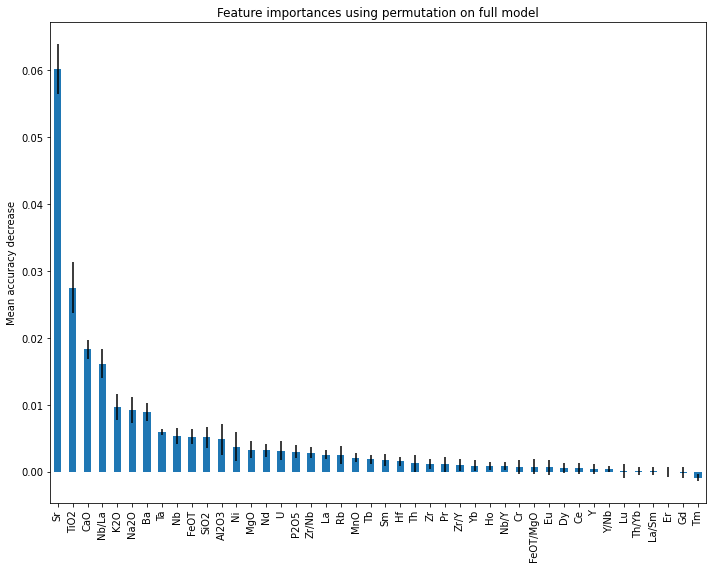

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
forest_importances[sorted_idx].plot.bar(yerr=result.importances_std[sorted_idx], ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [18]:
forest_importances[sorted_idx]

Sr          0.060178
TiO2        0.027473
CaO         0.018315
Nb/La       0.016117
K2O         0.009681
Na2O        0.009158
Ba          0.008948
Ta          0.005965
Nb          0.005338
FeOT        0.005233
SiO2        0.005128
Al2O3       0.004814
Ni          0.003715
MgO         0.003297
Nd          0.003192
U           0.003140
P2O5        0.002983
Zr/Nb       0.002826
La          0.002512
Rb          0.002459
MnO         0.002093
Tb          0.001884
Sm          0.001727
Hf          0.001518
Th          0.001256
Zr          0.001151
Pr          0.001099
Zr/Y        0.000994
Yb          0.000890
Ho          0.000785
Nb/Y        0.000785
Cr          0.000733
FeOT/MgO    0.000733
Eu          0.000628
Dy          0.000576
Ce          0.000471
Y           0.000419
Y/Nb        0.000366
Lu          0.000105
Th/Yb       0.000105
La/Sm       0.000052
Er         -0.000105
Gd         -0.000157
Tm         -0.000890
dtype: float64

In [19]:
from sklearn.model_selection import train_test_split
X = sampled_df[col]#, y = sampled_df["Tectonic_setting"]
X_train, X_test, y_train, y_test = train_test_split(sampled_df[labels],sampled_df["Tectonic_setting"],\
                                                    test_size=0.3, random_state=100)

from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_bal, y_bal = over_sampler.fit_resample(X_train, y_train)


from sklearn.ensemble import RandomForestClassifier
labels = np.array(sampled_df[features].columns.to_list())
rf = RandomForestClassifier(n_estimators = 500, random_state = 1)
rf.fit(X_bal, y_bal)
feature_importance = rf.feature_importances_
#indices = np.argsort(feature_importance)[::-1]

y_result= rf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_result))


              precision    recall  f1-score   support

         IAB       0.96      0.94      0.95      1003
        MORB       0.91      0.87      0.89       328
         OIB       0.91      0.96      0.94       580

    accuracy                           0.94      1911
   macro avg       0.93      0.92      0.93      1911
weighted avg       0.94      0.94      0.94      1911



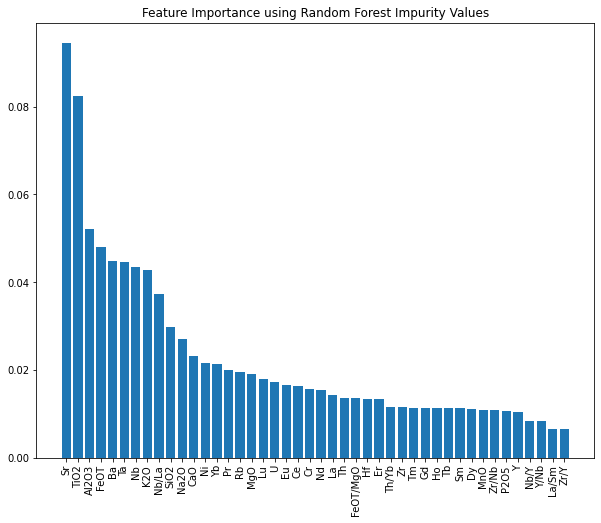

In [20]:
sorted_idx = rf.feature_importances_.argsort()[::-1]
fig, ax = plt.subplots(figsize= (10,8))
ax.set_title("Feature Importance using Random Forest Impurity Values")
ax.bar(labels[sorted_idx],feature_importance[sorted_idx], align = 'center')
ax.set_xticks(np.arange(len(labels)),labels = labels[sorted_idx],rotation = 90)
plt.show()

# Old features with some new ratios

`The random forest tree performs relatively well for the amount of features use in the training set. The only label below 90% accuracy is the MORB tectonic setting. Despite this an accuracy of 94% is reached on the test data set`.

In [ ]:
labels

In [21]:
def misclassifiedMap(ytest, X_test, model, df):
    misclassified = np.where(y_test != model.predict(X_test))
    correct = np.where(y_test == model.predict(X_test))
    from mpl_toolkits.basemap import Basemap
    plt.figure(figsize=(10, 8))
    m = Basemap(projection='cyl')
    plt.title("Miscclassified Values on black")
    m.drawmapboundary(fill_color='lightskyblue')
    m.fillcontinents(color='green',lake_color='aqua')
    m.drawcoastlines()
    #m.arcgisimage(server = "https://server.arcgisonline.com/arcgis/services", xpixels = 1500, verbose= True)
    m.scatter(df.iloc[correct[0]]["LONGITUDE"],df.iloc[correct[0]]["LATITUDE"], latlon=True, c = "orange")
    m.scatter(df.iloc[misclassified[0]]["LONGITUDE"],df.iloc[misclassified[0]]["LATITUDE"], latlon=True, c = "black", alpha = .3)
    plt.show()

In [22]:
#y_test = np.asarray(y_test)
misclassified = np.where(y_test != rf.predict(X_test))

In [23]:
correct = np.where(y_test == rf.predict(X_test))

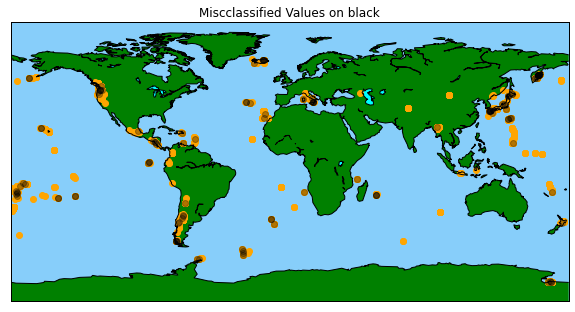

In [24]:
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(10, 8))
m = Basemap(projection='cyl')
plt.title("Miscclassified Values on black")
m.drawmapboundary(fill_color='lightskyblue')
m.fillcontinents(color='green',lake_color='aqua')
m.drawcoastlines()
#m.arcgisimage(server = "https://server.arcgisonline.com/arcgis/services", xpixels = 1500, verbose= True)
m.scatter(sampled_df.iloc[correct[0]]["LONGITUDE"],sampled_df.iloc[correct[0]]["LATITUDE"], latlon=True, c = "orange")
m.scatter(sampled_df.iloc[misclassified[0]]["LONGITUDE"],sampled_df.iloc[misclassified[0]]["LATITUDE"], latlon=True, c = "black", alpha = 0.3)
plt.show()

In [25]:
print(len(labels),len(feature_importance))

44 44


`The ratios that are traditionally compare with the chemicals in the basalts are found to be the least important features as per the Gini impurity value.`

In [26]:
labels = np.array(labels)

# testing with the first 8 features only

In [27]:
features = ["SiO2", "TiO2", "Al2O3", "FeOT", "MnO","MgO", "CaO", "Na2O"]
X = sampled_df[["SiO2", "TiO2", "Al2O3", "FeOT", "MnO","MgO", "CaO", "Na2O"]]
print(f"Classification report for {len(features)} features \n")
fea_impo, y_result,y_test, X_test, rf = randomForestTraining(X, sampled_df["Tectonic_setting"], sampled_df,features)

Classification report for 8 features 

              precision    recall  f1-score   support

         IAB       0.94      0.93      0.93      1003
        MORB       0.92      0.84      0.88       328
         OIB       0.88      0.94      0.91       580

    accuracy                           0.91      1911
   macro avg       0.91      0.90      0.90      1911
weighted avg       0.92      0.91      0.91      1911



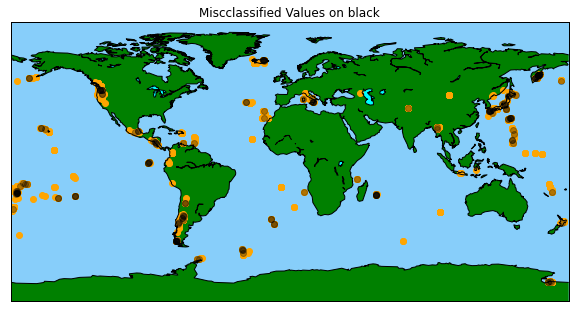

In [28]:
misclassifiedMap(y_test, X_test, rf, sampled_df)

# testing with 4 features only

In [29]:
features = ["SiO2", "TiO2", "Al2O3", "FeOT"]
X = sampled_df[features]
print(f"Classification report for {len(features)} features \n")
fea_impo, y_result,y_test, X_test, rf  = randomForestTraining(X, sampled_df["Tectonic_setting"], sampled_df,features)

Classification report for 4 features 

              precision    recall  f1-score   support

         IAB       0.89      0.86      0.88      1003
        MORB       0.79      0.73      0.76       328
         OIB       0.81      0.89      0.85       580

    accuracy                           0.85      1911
   macro avg       0.83      0.83      0.83      1911
weighted avg       0.85      0.85      0.85      1911



# Adding new ratios randomly

`I would like to now explore new ratios that could be useful in determining tectonic settings. I would do this ramdomly below:`

In [30]:
#reloading the original data frame so that the features added before are ignored
sampled_df = pd.read_csv(p)
newColsNames = []
for numerator in sampled_df[col].columns:
    for denominator in sampled_df[col].columns:
        if numerator != denominator:
            name = numerator +"/"+ denominator
            if name not in sampled_df.columns:
                inverse = denominator + "/"+numerator
                if inverse not in sampled_df.columns:
                    sampled_df[name] = sampled_df[numerator]/sampled_df[denominator]
                    newColsNames.append(name)
            
print(len(newColsNames))
newColsNames = [*set(newColsNames)]
print(len(newColsNames))
features = col
features = np.append(features,newColsNames)

630
630


In [31]:
sampled_df.replace([np.inf, -np.inf], np.nan, inplace=True)
sampled_df.dropna(inplace = True)
X = sampled_df[features]


In [32]:
from sklearn.model_selection import train_test_split
# X = sampled_df[col], y = sampled_df["Tectonic_setting"]
X_train, X_test, y_train, y_test = train_test_split(X,sampled_df["Tectonic_setting"],\
                                                    test_size=0.3, random_state=100)

from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_bal, y_bal = over_sampler.fit_resample(X_train, y_train)


from sklearn.ensemble import RandomForestClassifier
labels = sampled_df[features].columns.to_list()
rf = RandomForestClassifier(n_estimators = 500, random_state = 1)
rf.fit(X_bal, y_bal)

feature_importance = rf.feature_importances_
indices = np.argsort(feature_importance)[::-1]

y_result= rf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_result))



              precision    recall  f1-score   support

         IAB       0.98      0.94      0.96       953
        MORB       0.89      0.91      0.90       314
         OIB       0.94      0.98      0.96       598

    accuracy                           0.95      1865
   macro avg       0.94      0.95      0.94      1865
weighted avg       0.95      0.95      0.95      1865



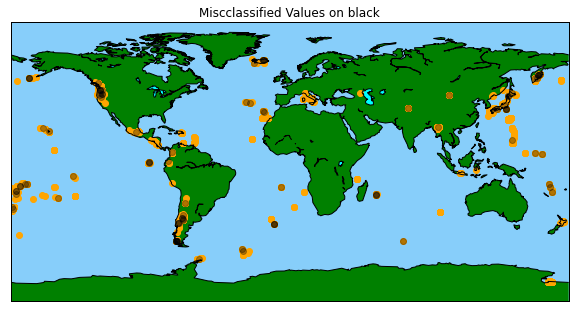

In [33]:
misclassifiedMap(y_test, X_test, rf, sampled_df)

## feature importance for randomly made features

In [34]:
sorted_idx = rf.feature_importances_.argsort()[::-1]

In [35]:
np.array(features)[sorted_idx][:30]

array(['Nb/Ba', 'Rb/Nb', 'K2O/Nb', 'K2O/Ta', 'Nb/U', 'Rb/Ta', 'Ta/Th',
       'Nb/Th', 'Na2O/Sr', 'Ta/U', 'Ba/Ta', 'TiO2/Na2O', 'K2O/Ce',
       'Ba/La', 'Al2O3/Sr', 'FeOT/Na2O', 'TiO2/Lu', 'TiO2/Sr', 'TiO2/Tm',
       'Dy/Yb', 'Sr/Tm', 'SiO2/Sr', 'Sr/Yb', 'Ho/Yb', 'Sr/Y', 'Sr/Er',
       'Sr/Lu', 'Sr/Ho', 'K2O/Pr', 'Ba/Ce'], dtype=object)

In [36]:
feature_importance[sorted_idx][:30]

array([0.0233978 , 0.02166855, 0.02133753, 0.01952103, 0.0182136 ,
       0.01596138, 0.01592947, 0.01560261, 0.01448142, 0.01416001,
       0.01286778, 0.01026835, 0.00983561, 0.00931818, 0.00930346,
       0.00830551, 0.00823187, 0.00819741, 0.00779708, 0.00757624,
       0.00738464, 0.00723253, 0.00708468, 0.00699751, 0.00699447,
       0.00696368, 0.0069445 , 0.00675658, 0.00658427, 0.00650376])

### interesting facts about Nb as it is in the to 3 for important features in this model: `Niobium is used in alloys including stainless steel. It improves the strength of the alloys, particularly at low temperatures. Alloys containing niobium are used in jet engines and rockets, beams and girders for buildings and oil rigs, and oil and gas pipelines. This element also has superconducting properties.`

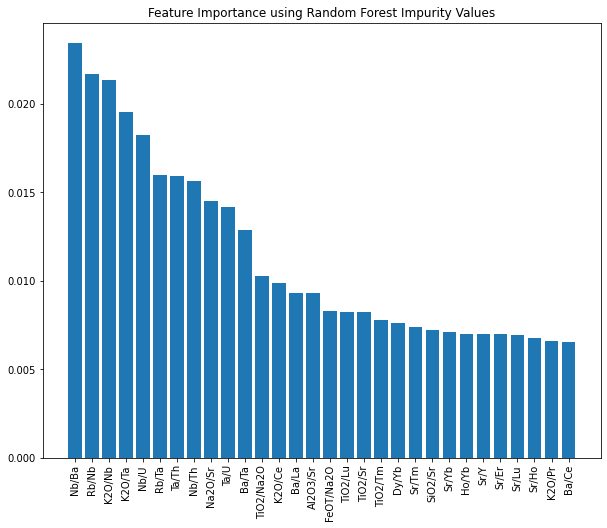

In [37]:
plt.figure(figsize= (10,8))
plt.title("Feature Importance using Random Forest Impurity Values")
plt.bar(np.array(features)[sorted_idx][:30],feature_importance[sorted_idx][:30], align = 'center')
plt.xticks(rotation = 90)
plt.show()

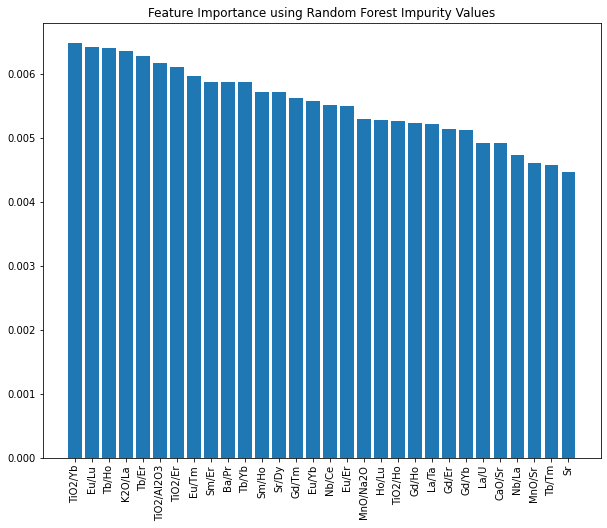

In [38]:
plt.figure(figsize= (10,8))
plt.title("Feature Importance using Random Forest Impurity Values")
plt.bar(np.array(features)[sorted_idx][30:60],feature_importance[sorted_idx][30:60], align = 'center')
plt.xticks(rotation = 90)
plt.show()

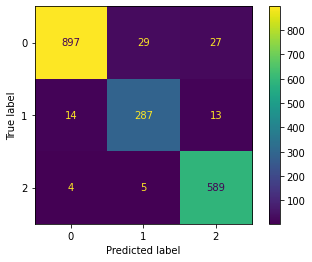

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(y_test, y_result)
cm_display =ConfusionMatrixDisplay(confusion_matrix = confusion_matrix) #,display_labels = [False, True])
cm_display.plot()
plt.show()

### Random forest with 8 features only

In [40]:
X = sampled_df[np.array(features)[sorted_idx][:9]]
print("Classification report for 8 features \n")
fea_impo, y_res, y_test, X_test, rf = randomForestTraining(X, sampled_df["Tectonic_setting"], sampled_df,features)

Classification report for 8 features 

              precision    recall  f1-score   support

         IAB       0.96      0.90      0.93       953
        MORB       0.84      0.87      0.85       314
         OIB       0.88      0.94      0.91       598

    accuracy                           0.91      1865
   macro avg       0.89      0.90      0.90      1865
weighted avg       0.91      0.91      0.91      1865



In [41]:
X

,Nb/Ba,Rb/Nb,K2O/Nb,K2O/Ta,Nb/U,Rb/Ta,Ta/Th,Nb/Th,Na2O/Sr
0,0.001933,14.310345,0.258621,2.500000,3.135135,138.333333,0.150000,1.450000,0.005924
1,0.011335,9.038294,0.314401,4.467345,4.369372,128.425927,0.196246,2.788477,0.007312
2,0.010481,8.832406,0.318750,4.422245,4.269526,122.538104,0.196723,2.729278,0.008360
3,0.010311,9.355057,0.320591,5.054186,4.711937,147.484529,0.189025,2.980013,0.006602
4,0.010739,10.054944,0.330387,5.542175,3.970183,168.669440,0.148810,2.496263,0.010478
...,...,...,...,...,...,...,...,...,...
6363,0.024422,5.421053,0.315789,3.000000,9.500000,51.500000,0.500000,4.750000,0.007723
6364,0.289703,0.404423,0.032385,0.450549,42.200000,5.626374,1.181818,16.441558,0.025628
6365,0.225253,0.442907,0.041522,0.571429,41.285714,6.095238,1.235294,17.000000,0.020098
6366,0.231227,0.570874,0.042718,0.656716,29.855072,8.776119,0.728261,11.195652,0.040038


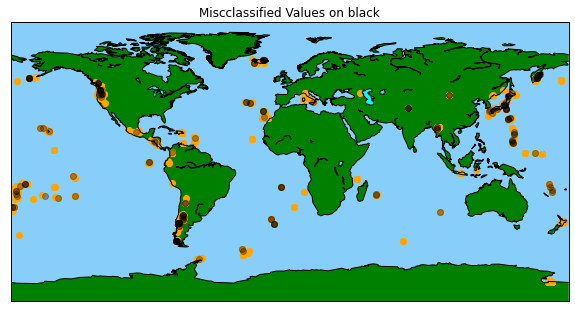

In [42]:
misclassifiedMap(y_test, X_test, rf, sampled_df)

## Traing the random forest with the 4 most importan features as per the Gini value

In [43]:
X = sampled_df[np.array(features)[sorted_idx][:4]]

print("Classification report for 4 features \n")
fea_impo, y_res, y_test,X_test, rf = randomForestTraining(X, sampled_df["Tectonic_setting"], sampled_df,features)

Classification report for 4 features 

              precision    recall  f1-score   support

         IAB       0.94      0.88      0.91       953
        MORB       0.72      0.75      0.74       314
         OIB       0.78      0.83      0.81       598

    accuracy                           0.85      1865
   macro avg       0.81      0.82      0.82      1865
weighted avg       0.85      0.85      0.85      1865



In [44]:
X

,Nb/Ba,Rb/Nb,K2O/Nb,K2O/Ta
0,0.001933,14.310345,0.258621,2.500000
1,0.011335,9.038294,0.314401,4.467345
2,0.010481,8.832406,0.318750,4.422245
3,0.010311,9.355057,0.320591,5.054186
4,0.010739,10.054944,0.330387,5.542175
...,...,...,...,...
6363,0.024422,5.421053,0.315789,3.000000
6364,0.289703,0.404423,0.032385,0.450549
6365,0.225253,0.442907,0.041522,0.571429
6366,0.231227,0.570874,0.042718,0.656716


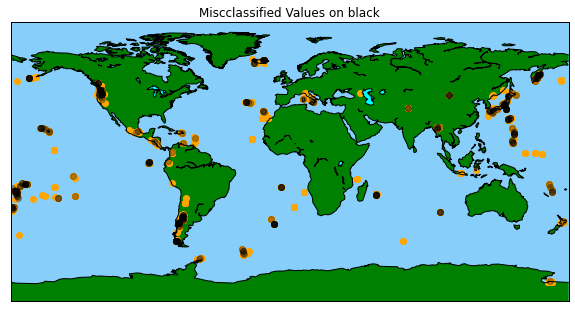

In [45]:
misclassifiedMap(y_test, X_test, rf, sampled_df)

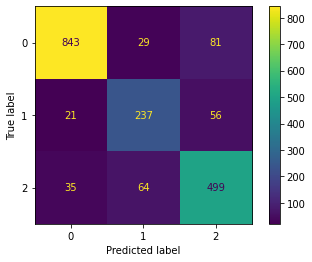

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(y_test, y_res)
cm_display =ConfusionMatrixDisplay(confusion_matrix = confusion_matrix) #,display_labels = [False, True])
cm_display.plot()
plt.show()

In [47]:
X = sampled_df[np.array(features)[sorted_idx][:2]]

print("Classification report for 4 features \n")
fea_impo, y_res, y_test,X_test, rf = randomForestTraining(X, sampled_df["Tectonic_setting"], sampled_df,features)

Classification report for 4 features 

              precision    recall  f1-score   support

         IAB       0.90      0.85      0.87       953
        MORB       0.58      0.65      0.61       314
         OIB       0.68      0.69      0.68       598

    accuracy                           0.76      1865
   macro avg       0.72      0.73      0.72      1865
weighted avg       0.77      0.76      0.77      1865



In [48]:
X = sampled_df[np.array(features)[sorted_idx][:3]]

print("Classification report for 4 features \n")
fea_impo, y_res, y_test,X_test, rf = randomForestTraining(X, sampled_df["Tectonic_setting"], sampled_df,features)

Classification report for 4 features 

              precision    recall  f1-score   support

         IAB       0.92      0.87      0.90       953
        MORB       0.68      0.70      0.69       314
         OIB       0.76      0.82      0.79       598

    accuracy                           0.83      1865
   macro avg       0.79      0.80      0.79      1865
weighted avg       0.83      0.83      0.83      1865

